# Analyse de trajectoires à l'aide de fichiers .gpx

Ce notebook sert à analyser des trajectoires en vélo. Il permet de déterminer la puissance mécanique transférée par le cycliste au vélo.

In [1]:
import pylab
import gpxpy
import gpxpy.gpx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

import folium
from folium import plugins, IFrame
from folium.features import *

import os
from pandas import DataFrame
dir = os.path.dirname(os.path.realpath('__file__'))
pylab.rcParams['figure.figsize'] = (24.0, 12.0) #configure the figure

def lon_lat_to_xy(lon, lat, R = 6371000.0):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x =  R * np.cos(lat_r[0]) * lon_r
    y = R * lat_r
    return x,y,

def lon_lat_to_cartesian(lon, lat, R = 6371000.0):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x =  R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x,y,z

def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

def rot(v,theta,alpha):
    
    R = ([[np.cos(theta)*np.cos(alpha), -np.sin(theta), -np.cos(theta)*np.sin(alpha)], [np.sin(theta)*np.cos(alpha), np.cos(theta), np.sin(theta)*np.sin(alpha)], [np.sin(alpha)], 0., np.cos(alpha)])
    RT=np.transpose(R)
    return R*V

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [2]:
# Parsing an existing file:
# -------------------------

file_name = 'Tour_de_la_Montagne_de_Chabre.gpx'
gpx_file = open(file_name, 'r')
gpx = gpxpy.parse(gpx_file)

print("{} track(s)".format(len(gpx.tracks)))
track = gpx.tracks[0]

print("{} segment(s)".format(len(track.segments)))
segment = track.segments[0]

print("{} point(s)".format(len(segment.points)))

data = []
segment_length = segment.length_3d()

for point_idx, point in enumerate(segment.points):
    data.append([point.longitude, point.latitude,
                 point.elevation, point.time, segment.get_speed(point_idx)])
    
columns = ['Longitude', 'Latitude', 'Altitude', 'Time', 'Speed']
df = DataFrame(data, columns=columns)

1 track(s)
1 segment(s)
1531 point(s)


In [3]:
points = []
for track in gpx.tracks:
  for segment in track.segments: 
      for point in segment.points:
        points.append(tuple([point.latitude, point.longitude]))

mymap = folium.Map( location=[ df.Latitude.mean(), df.Longitude.mean() ], zoom_start=10, tiles=None)
folium.TileLayer('Stamen Terrain', name='Stamen Terrain').add_to(mymap)
folium.PolyLine(points, color='red', weight=4.5, opacity=.5).add_to(mymap)
mymap


# Obtain the positions, velocity and acceleration

In [4]:
x_temp,y_temp = lon_lat_to_xy(df['Longitude'], df['Latitude'], R = 6371000.0)

t = (df['Time'] - df['Time'][0]) / np.timedelta64(1, 's')
x = x_temp - x_temp[0]
y = y_temp - y_temp[0]
z = df['Altitude']
output_file = "positions.csv"
DataFrame(np.transpose([t,x,y,z])).to_csv(output_file)

#Calcul des composantes du vecteur vitesse
v_x = np.gradient(x,t)
v_y = np.gradient(y,t)
v_z = np.gradient(z,t)

#Calcul des composantes du vecteur accélération
a_x = np.gradient(v_x,t)
a_y = np.gradient(v_y,t)
a_z = np.gradient(v_z,t)

#Calcul des incréments de position
dx = np.diff(x)
dy = np.diff(x)
dz = np.diff(x)

#Calcul de la distance cumulée
ds = np.sqrt(dx*dx + dy*dy + dz*dz)
s = np.cumsum(ds)
s = np.insert(s, 0, 0.)

[]

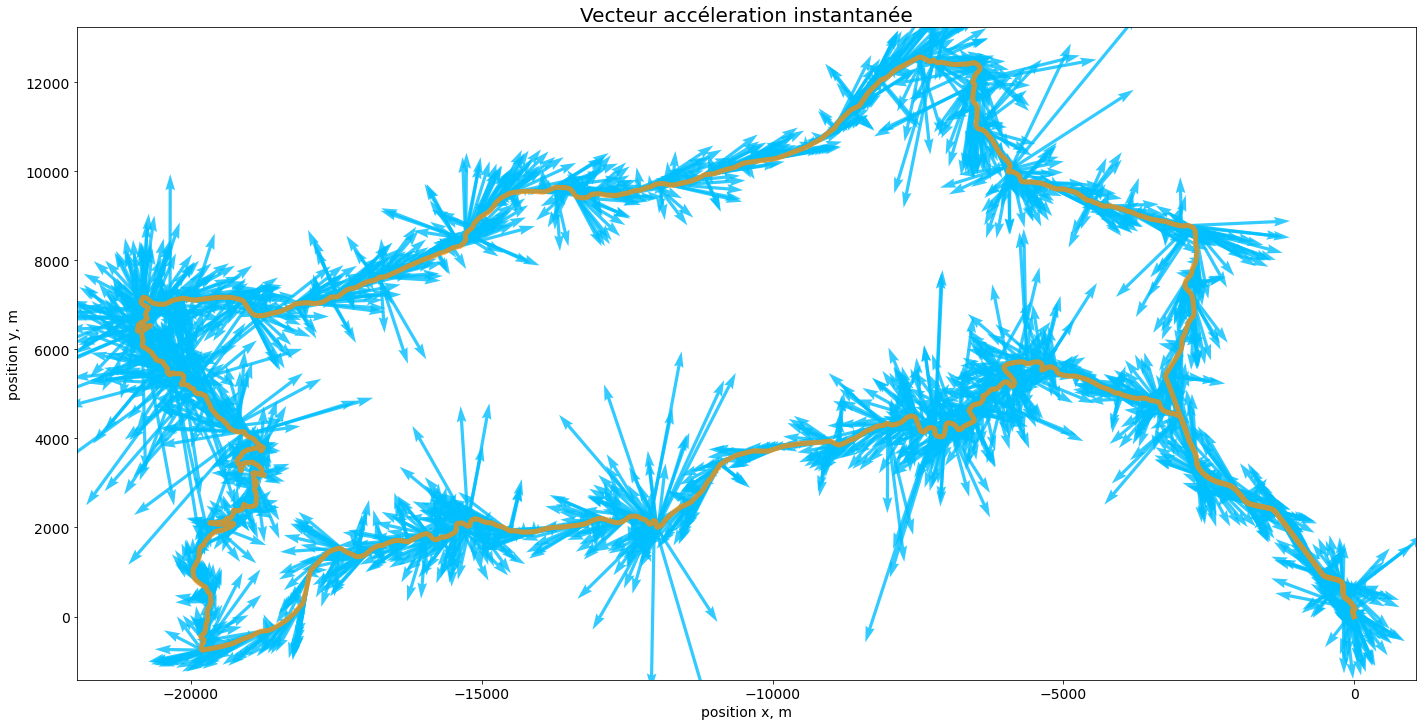

In [41]:
plt.title('Vecteur vitesse instantanée', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('position x, m', fontsize=14)
plt.ylabel('position y, m', fontsize=14)
plt.plot(x,y,color='darkorange', linewidth=5, alpha=0.5)
plt.quiver(x, y, v_x, v_y, color='deepskyblue', alpha=0.8, scale=200)
plt.plot()

[]

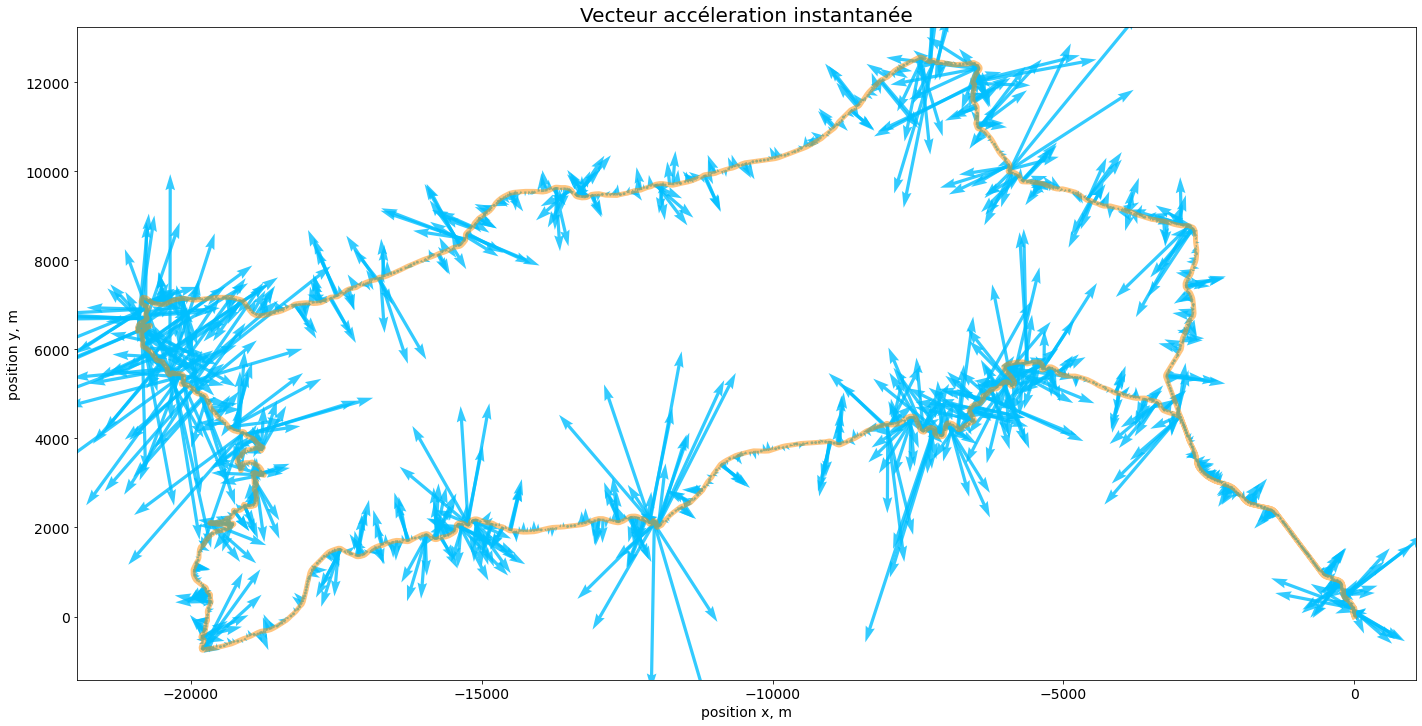

In [42]:
plt.title('Vecteur accéleration instantanée', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('position x, m', fontsize=14)
plt.ylabel('position y, m', fontsize=14)
plt.plot(x,y,color='darkorange', linewidth=5, alpha=0.5)
plt.quiver(x, y, a_x, a_y, color='deepskyblue', alpha=0.8, scale=20)
plt.plot()